# LSH Density Estimation Performance Assessment on 3-Dimensional data

Assessing the performance of the LSH density estimation algorithm

In [15]:
import os, sys

sys.path.append(os.path.join(".."))

from benchmark_synthetic_data import sample_blobs
from lsh_density.lsh_based_kde import run_high_dim_kde, lsh_granularity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from mpl_toolkits.mplot3d import Axes3D
import random as rd

#### Exploration of sklearn's `sklearn.datasets.make_blobs`

Given the objective is to assess the performance of the LSH density estimation algorithm, we will use `sklearn.datasets.make_blobs` to generate synthetic data. This function allows us to create a dataset with a specified number of samples, centers, and cluster standard deviation.

By creating a dataset with multiple clusters, we will be able to set a ground truth for the density estimation. If we count the number of points in each cluster, we can compare the estimated density against this ground truth.

In [16]:
samples, labels = sample_blobs(n_samples=1000, n_features=2, clusters_centers=1, cluster_std=1, random_state=42, verbose=True)
print()
print("Samples shape:", samples.shape)
print("Set of labels:", set(labels))

Generating 1000 samples with 2 features each, 1 cluster centers, and standard deviation 1.
Generated 1000 samples with 2 features each.

Samples shape: (1000, 2)
Set of labels: {0}


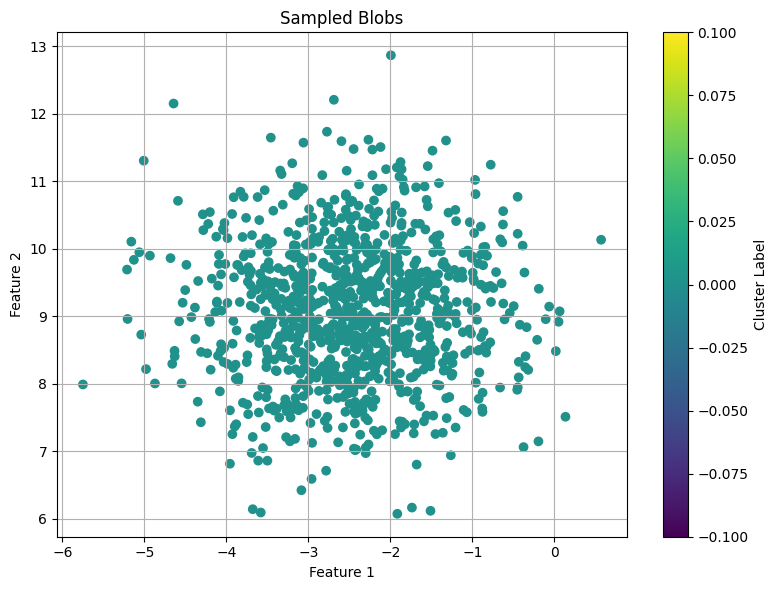

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap='viridis')
plt.title('Sampled Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
samples, labels = sample_blobs(n_samples=1000, n_features=2, clusters_centers=3, cluster_std=1, random_state=42, verbose=True)
print()
print("Samples shape:", samples.shape)
print("Set of labels:", set(labels))

Generating 1000 samples with 2 features each, 3 cluster centers, and standard deviation 1.
Generated 1000 samples with 2 features each.

Samples shape: (1000, 2)
Set of labels: {0, 1, 2}


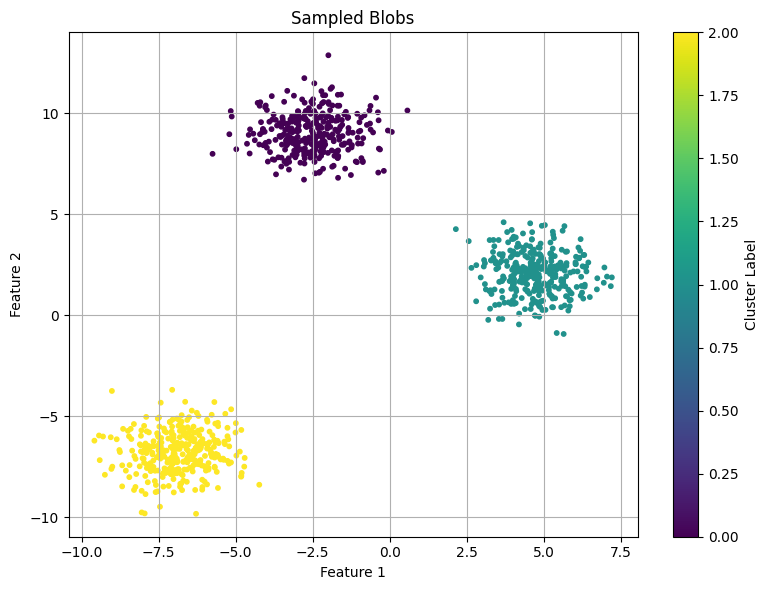

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Sampled Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.tight_layout()
plt.show()

#### LSH Density Estimation on 3D Data

We will generate a 3D dataset using `sample_blobs` and then apply the LSH density estimation algorithm. The performance will be assessed by comparing the estimated density against the ground truth.

<ins>Reminder:</ins> The LSH density estimation algorithm is designed to work with high-dimensional data (at least 3D, 2D leading to hashing the data in only 2 buckets). Therefore, we will first try on a 3D dataset.

Additionally, given the `sample_blobs` function generates clusters of equal size, we will need to create a more complex dataset, to plot a histogram that does not only show a single peak.

In [20]:
all_samples = []
all_labels = []
for _ in range(15):
    n_samples = rd.randint(10, 1000)
    std = rd.uniform(0.1, 1.0)
    clusters_centers = rd.randint(1, 10)
    samples, labels = sample_blobs(n_samples=n_samples, n_features=3, clusters_centers=clusters_centers, cluster_std=std, random_state=42, verbose=False)
    all_samples += samples.tolist()
    all_labels += labels
    
all_samples = np.array(all_samples)
print()
print("All samples shape:", all_samples.shape)
print("Set of labels:", set(all_labels))


All samples shape: (8214, 3)
Set of labels: {0, 1, 2, 3, 4, 5, 6, 7}


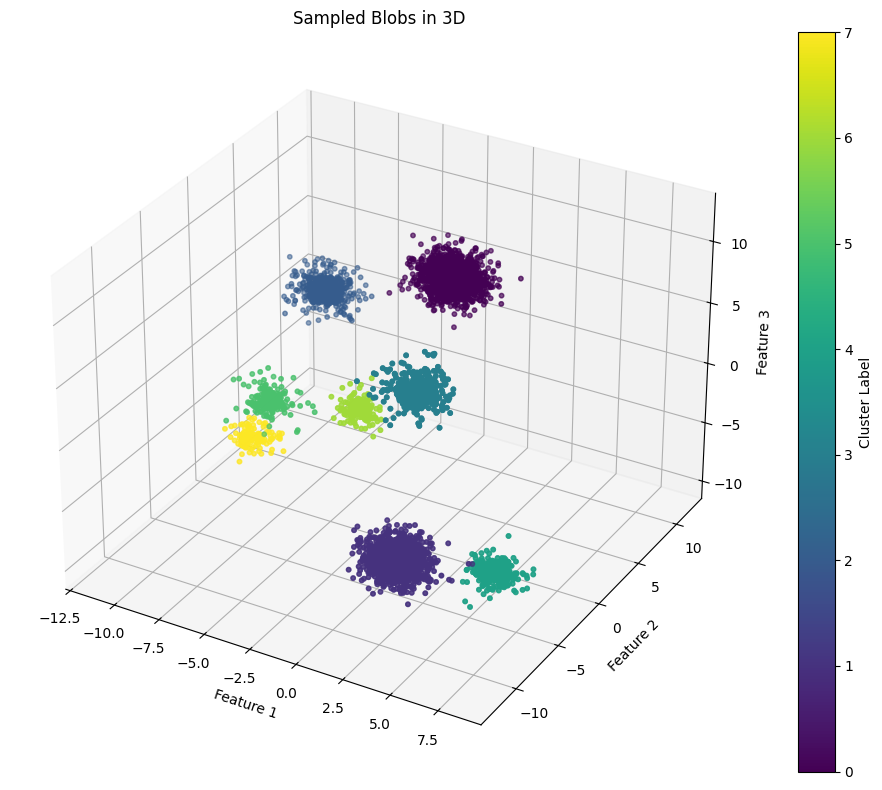

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_samples[:, 0], all_samples[:, 1], all_samples[:, 2], c=all_labels, cmap='viridis', s=10)
ax.set_title('Sampled Blobs in 3D')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.colorbar(ax.scatter(all_samples[:, 0], all_samples[:, 1], all_samples[:, 2], c=all_labels, cmap='viridis', s=10), label='Cluster Label')
plt.grid()
plt.tight_layout()
plt.show()

Now that the sample dataset is generated, we can proceed with the LSH density estimation, and its performance assessment.

---

#### Computing the high dimensional density estimation for the generated dataset

In [22]:
lsh_densities = run_high_dim_kde(dataset=all_samples, hash_bits_per_table=20, number_of_hash_tables=30, random_state=42, verbose=True)

Running LSH-based KDE with 20 hash bits per table and 30 hash tables.
Preparing hash tables and planes...
Hash tables and planes prepared.
Hashing the dataset...
Dataset hashed.
Computing densities for the dataset...
Densities computed.
Computed densities using LSH and SimHash for 8214 samples.


In [23]:
theta, cosine_similarity_threshold = lsh_granularity(n_bits=20, p_target=0.5)
print(f"Effective angular threshold: {theta:.4f} rad")
print(f"Equivalent cosine similarity: {cosine_similarity_threshold:.4f}")

Effective angular threshold: 0.1070 rad
Equivalent cosine similarity: 0.9943


---

#### Performance Assessment of LSH Density Estimation

To perform the performance assessment, we will compare the estimated density against the ground truth. The ground truth will be defined by brute force. We will compute the density of points that fall within a certain cosine similarity threshold.

That similarity threshold will be defined by the LSH algorithm's parameters. We will then compare the estimated density against the ground truth density. That way, we can properly assess the performance of the LSH density estimation algorithm.

Therefore, let `similarity_threshold = cosine_similarity_threshold`.

In [24]:
cosine_similarity_matrix = cosine_similarity(all_samples)

# Calculate the exact density based on cosine similarity threshold
neighbours_count = (cosine_similarity_matrix >= cosine_similarity_threshold).sum(axis=1) - 1
ground_truth_densities = neighbours_count / len(neighbours_count)


----

##### Spearman Correlation Coefficient

The Spearman correlation coefficient will be used to assess the performance of the LSH density estimation algorithm. The Spearman correlation coefficient is a non-parametric measure of rank correlation, which assesses how well the relationship between two variables can be described using a monotonic function. In this case, it will be used to compare the estimated density against the ground truth density.

The result will be a value between -1 and 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation.
Here, we expect a value close to 1, indicating that the estimated density is closely related to the ground truth density.

In [25]:
rho, _ = spearmanr(ground_truth_densities, lsh_densities)
mae = np.mean(np.abs(ground_truth_densities - lsh_densities))

print("Spearman correlation:", rho)
print("Mean absolute error:", mae)

Spearman correlation: 0.9408124268086456
Mean absolute error: 0.041651012748479835


The value of the Spearman correlation coefficient is of about 0.94, indicating a strong positive correlation between the estimated density and the ground truth density. This suggests that the LSH density estimation algorithm is performing well in estimating the density of the dataset.
It remains to be seen how well it performs on more complex datasets, but the initial results are promising.

----

##### Visualizing the Estimated Density Against the Ground Truth Density

We can also visualize the estimated density against the ground truth density to get a better understanding of the performance of the LSH density estimation algorithm. We will plot the estimated density and the ground truth density on the same graph to visually assess the performance of the algorithm.

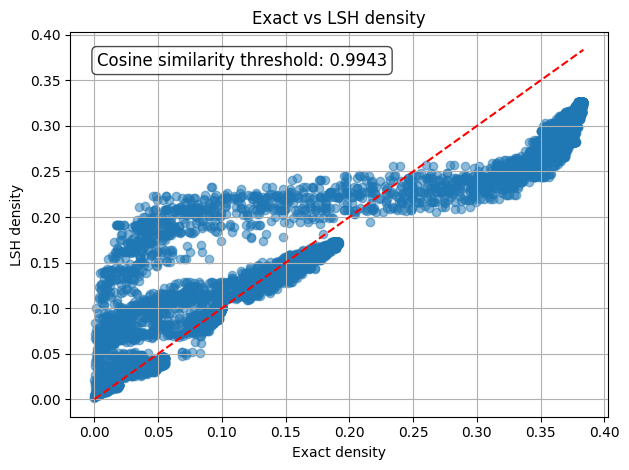

In [26]:
plt.scatter(ground_truth_densities, lsh_densities, alpha=0.5)
plt.text(
    0.05, 0.95,
    f"Cosine similarity threshold: {cosine_similarity_threshold:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
plt.xlabel("Exact density")
plt.ylabel("LSH density")
plt.title("Exact vs LSH density")
plt.plot([ground_truth_densities.min(), ground_truth_densities.max()],
         [ground_truth_densities.min(), ground_truth_densities.max()],
         color='r', linestyle='--')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join("..", "results", "plots", "exact_vs_lsh_density.png"))
plt.show()

There are a few comments to be made about the visualization:

1. The LSH density estimation algorithm seems to be perforrming well overall, as the points are "close" to the red line, which represents the exact values (LSH density estimation = ground truth density).

2. There are still two sections where the estimated density is not as close to the ground truth density. Indeed, **low density areas are "overestimated"** by the LSH density estimation algorithm, while **high density areas are "underestimated"**. This is likely due to the nature of the LSH algorithm, which is **designed to work with high-dimensional data** and may not perform as well on lower-dimensional data. 
To assess if this is the case, we will need to test the LSH density estimation algorithm on higher-dimensional data.

---

##### Visualizing the Estimated Density Against the Ground Truth Density - Histogram

We can also compare the histogram of the estimated density against the histogram of the ground truth density. This will allow us to see how well the estimated density matches the ground truth density.

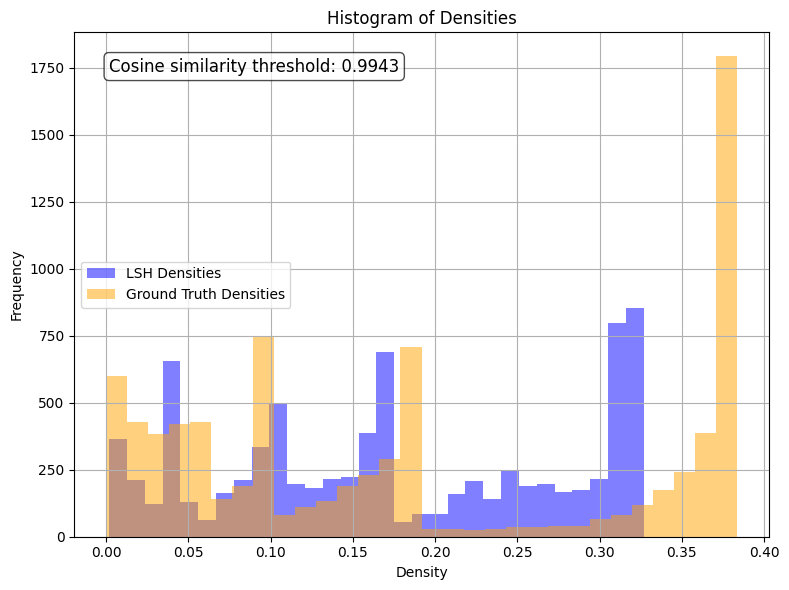

In [27]:
# Plotting the LSH densities and ground truth densities on the same histogram
plt.figure(figsize=(8, 6))
plt.hist(lsh_densities, bins=30, alpha=0.5, label='LSH Densities', color='blue')
plt.hist(ground_truth_densities, bins=30, alpha=0.5, label='Ground Truth Densities', color='orange')
plt.text(
    0.05, 0.95,
    f"Cosine similarity threshold: {cosine_similarity_threshold:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.title('Histogram of Densities')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join("..", "results", "plots", "density_histogram.png"))
plt.show()

There are a few comments to be made about the histogram visualization:

1. The histogram of the estimated density and the histogram of the ground truth density are quite similar in shape and general distribution, with each having 6 peaks. This is a good indication that the LSH density estimation algorithm can perform well, as it is able to capture the general distribution of the data.

2. The ground truth density histogram has a higher peak than the estimated density histogram, which indicates that the LSH density estimation algorithm is underestimating the density of the data. As mentioned earlier, this is likely due to the nature of the LSH algorithm, which is designed to work with high-dimensional data and may not perform as well on lower-dimensional data.

3. It seems that the range of the estimated density is smaller than the range of the ground truth density. We will need to investigate this further to understand why this is the case. It could be due to the parameters used in the LSH density estimation algorithm or the nature of the data itself.

**We can conclude that the LSH density estimation algorithm is performing well overall, but there are still some areas where it can be improved. We will now proceed to test the LSH density estimation algorithm on higher-dimensional data, as we suspect that it may perform better on such data.**

The performance assessment of the LSH density estimation algorithm on higher-dimensional data can be found in the following notebook: [LSH Density Estimation Performance Assessment on Higher-Dimensional Data](benchmark_ground_truth_nd.ipynb).